In [39]:
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from pathlib import Path

# --- Configuration ---
CONFIG_FILE = 'config_test.json'
config = json.load(open(CONFIG_FILE))
OUTPUT_DIR = Path(config.get('output_directory', 'output_bin/'))

def plot_metrics(selection: str):
    """
    Plot key portfolio metrics over time for a strategy or an account:
      1) Portfolio Unbalance
      2) Portfolio Return %
      3) Portfolio Realized PnL
      4) Portfolio Unrealized PnL
    
    For an account:
      - Metrics are loaded directly from pnl_timeline_account_<account>.json.
    """
    # Determine whether selection is a strategy or account
    strategies = list(config.get('strategy', {}).keys())
    accounts   = list(config.get('account_allocation', {}).keys())
    is_strategy = selection in strategies
    is_account  = selection in accounts
    if not (is_strategy or is_account):
        print(f"Error: '{selection}' is neither a valid strategy nor account.")
        return
    
    # Helper to load a single entity's timeline
    def load_timeline(entity: str, is_acc: bool):
        if is_acc:
            path = OUTPUT_DIR / f"pnl_timeline_account_{entity}.json"
        else:
            path = OUTPUT_DIR / f"pnl_timeline_{entity}.json"
        if not path.exists():
            print(f"Warning: {path} not found")
            return {}
        return json.load(open(path))
    
    # Collect timeline data
    timeline_data = {}
    timestamps = set()
    
    if is_strategy:
        data = load_timeline(selection, False)
        timeline_data[selection] = data
        timestamps.update(data.keys())
    else:
        # Account: load the precomputed account timeline
        data = load_timeline(selection, True)
        timeline_data[selection] = data
        timestamps.update(data.keys())
    
    # Prepare sorted timestamps and datetime list
    sorted_ts = sorted(timestamps, key=lambda s: datetime.fromisoformat(s))
    ts_dt = [datetime.fromisoformat(ts) for ts in sorted_ts]
    
    # Create subplots
    fig, axs = plt.subplots(4, 1, figsize=(12, 16), sharex=True)
    
    # 1) Portfolio Unbalance
    for label, series in timeline_data.items():
        vals = [series.get(ts, {}).get('portfolio_unbalance') for ts in sorted_ts]
        axs[0].plot(ts_dt, vals, label=label)
    axs[0].set_title('Portfolio Unbalance')
    axs[0].set_ylabel('Unbalance Ratio')
    axs[0].legend()
    axs[0].grid(True)
    
    # 2) Portfolio Return %
    for label, series in timeline_data.items():
        vals = [series.get(ts, {}).get('portfolio_return_pct') for ts in sorted_ts]
        axs[1].plot(ts_dt, vals, label=label)
    axs[1].set_title('Portfolio Return %')
    axs[1].set_ylabel('Return (%)')
    axs[1].grid(True)
    
    # 3) Portfolio Realized PnL
    for label, series in timeline_data.items():
        vals = [series.get(ts, {}).get('portfolio_realized_pnl') for ts in sorted_ts]
        axs[2].plot(ts_dt, vals, linestyle='-', label=f"{label} Realized")
    axs[2].set_title('Portfolio Realized PnL')
    axs[2].set_ylabel('PnL (USD)')
    axs[2].grid(True)
    
    # 4) Portfolio Unrealized PnL
    for label, series in timeline_data.items():
        vals = [series.get(ts, {}).get('portfolio_unrealized_pnl') for ts in sorted_ts]
        axs[3].plot(ts_dt, vals, linestyle='--', label=f"{label} Unrealized")
    axs[3].set_title('Portfolio Unrealized PnL')
    axs[3].set_ylabel('PnL (USD)')
    axs[3].grid(True)
    axs[3].legend()
    
    # X-axis formatting
    axs[3].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    plt.xticks(rotation=45)
    plt.xlabel('Timestamp')
    plt.tight_layout()
    
    plt.show()



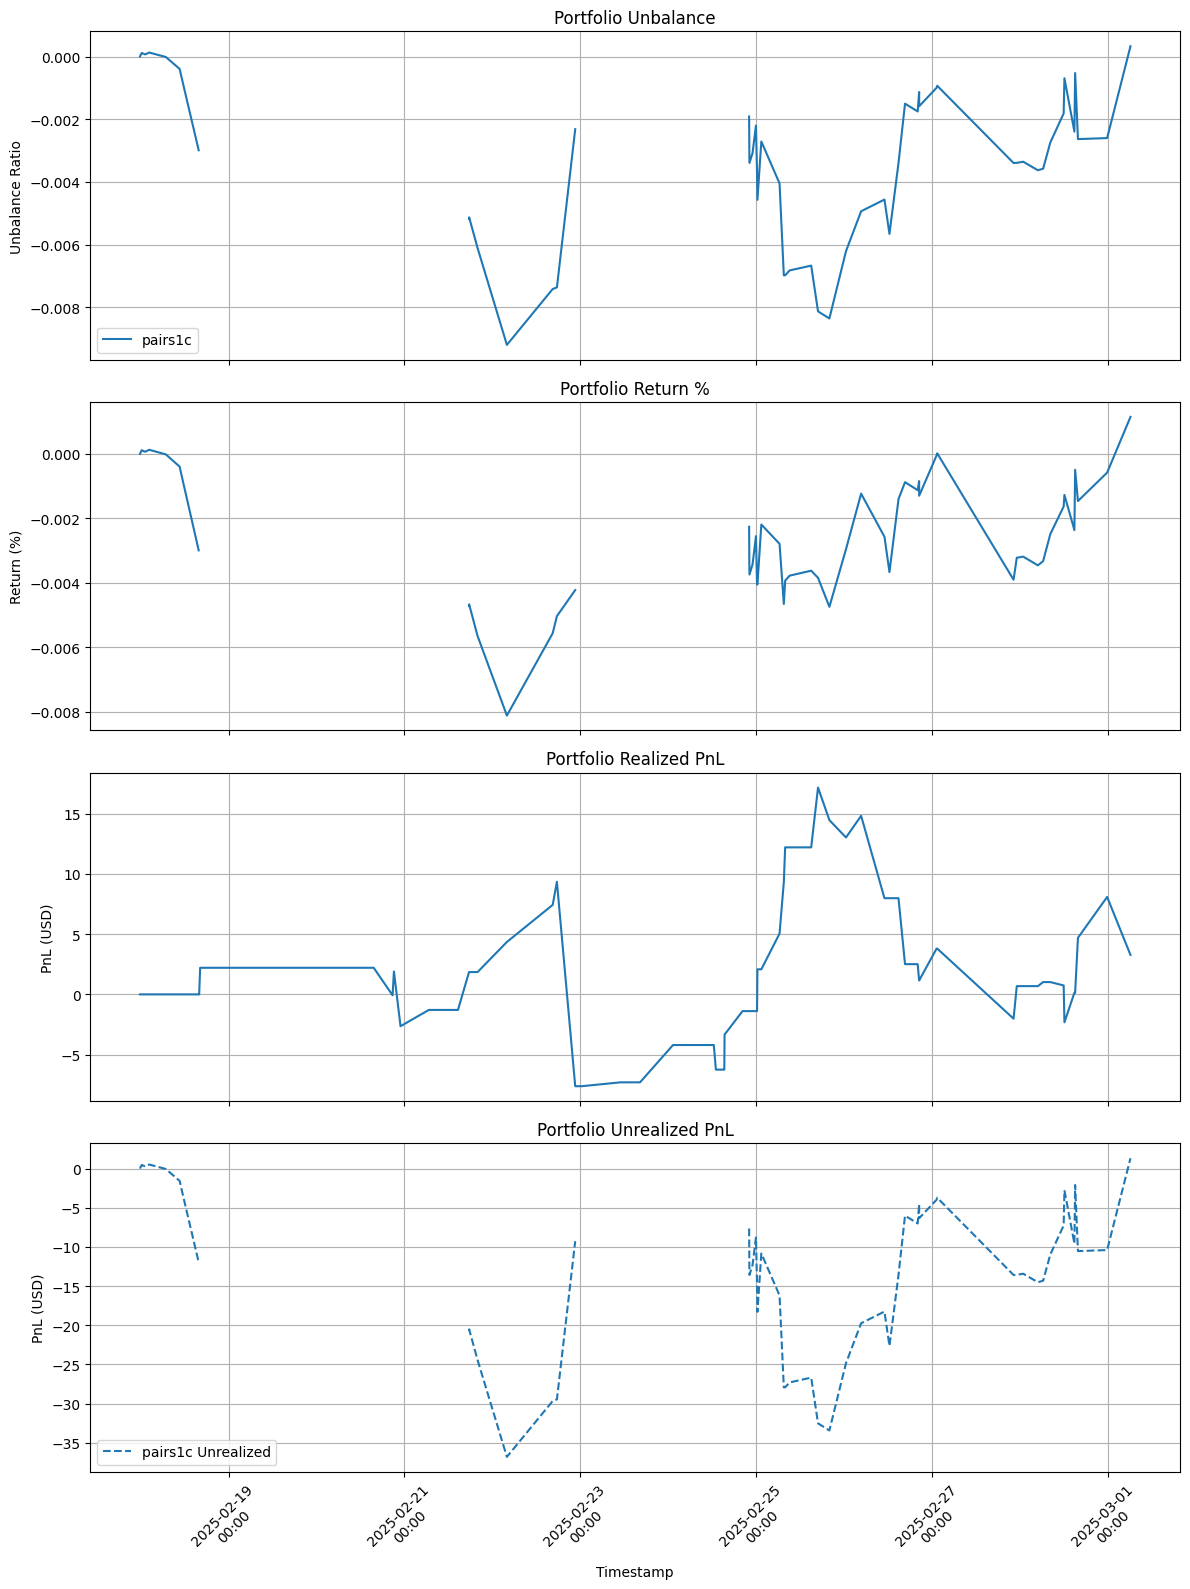

In [41]:
plot_metrics('pairs1c')


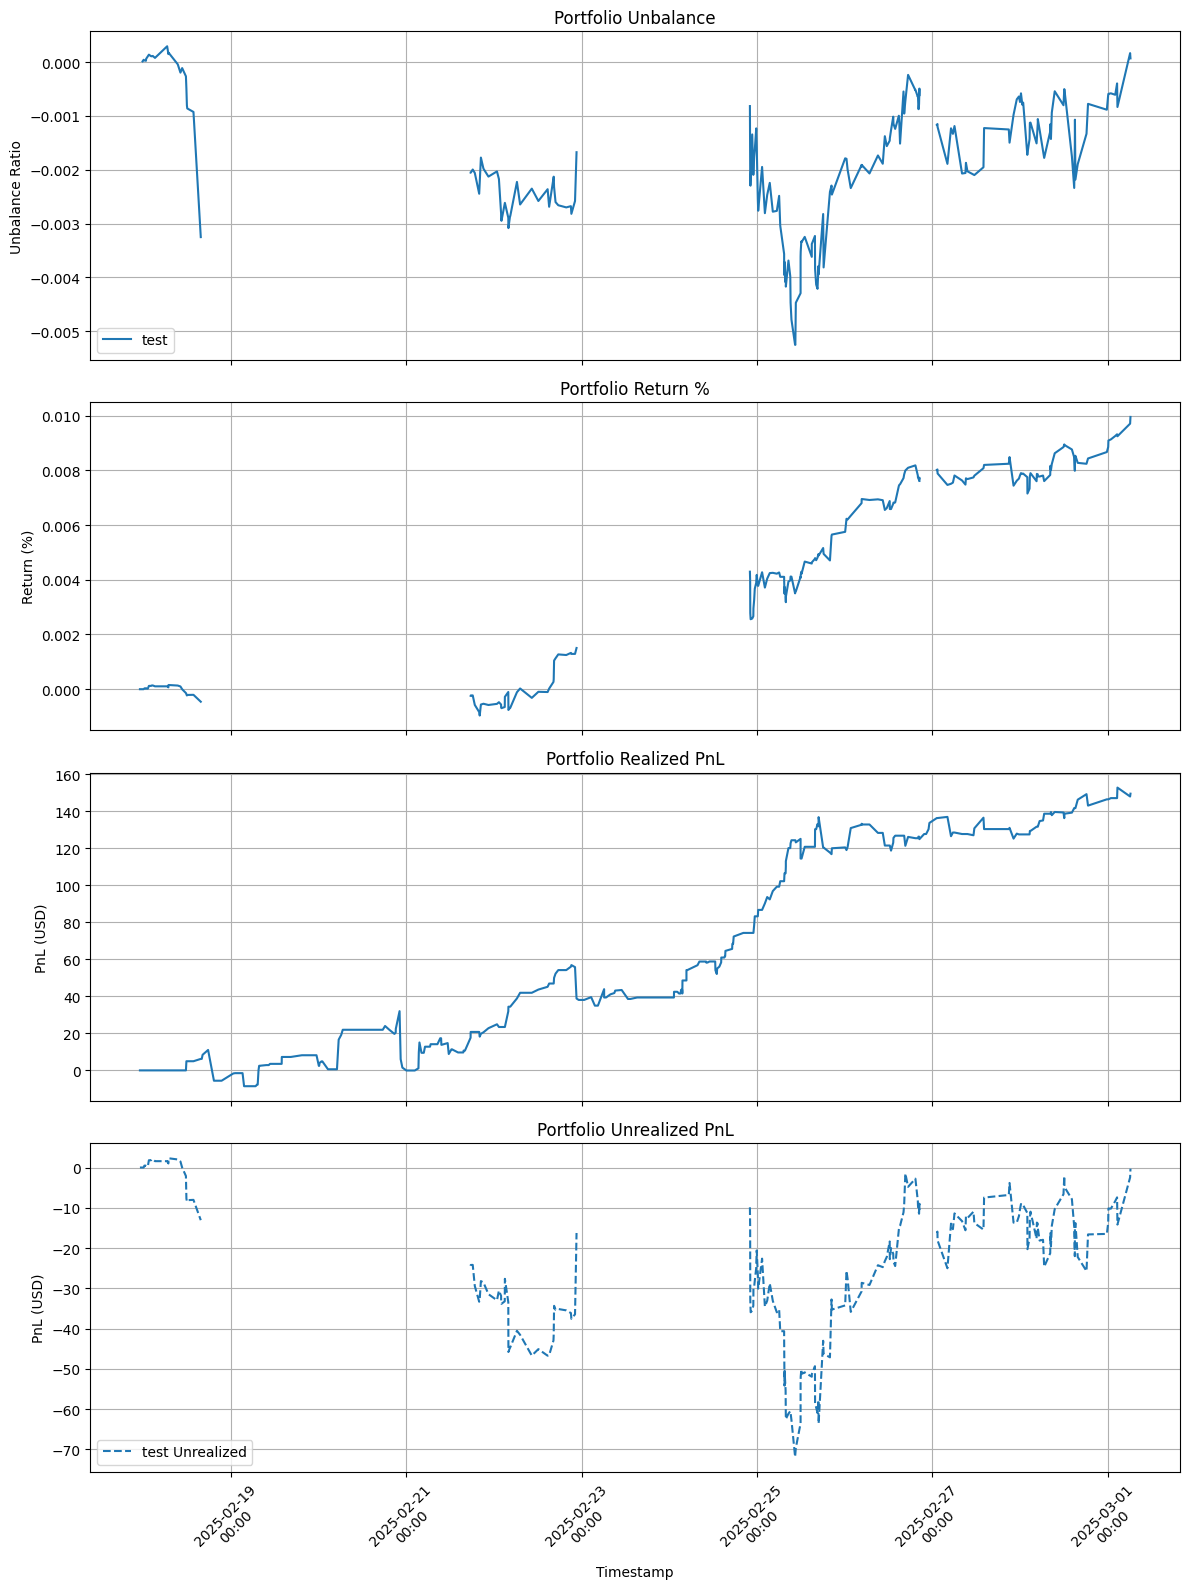

: 

: 

: 

: 

: 

In [ ]:
plot_metrics('test')